In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

from ferramentas import carregar_mnist

2024-12-05 16:00:13.617564: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-05 16:00:14.294589: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<a id='import_data'></a>

### __1. Importar e pré-processar os dados:__
<font size=3>
    
Como exemplo de tarefa de regressão supervisionada, utilizaremos o clássico conjunto de dados [MNIST](https://en.wikipedia.org/wiki/MNIST_database) de dígitos manuscritos. Esses dados estão disponíveis no [repositório de dados do Keras](https://keras.io/api/datasets/mnist/). Os dados $x$ correspondem às imagens como matrizes de pixels na escala de cinza, já os dados $y$ são números inteiros representando os respectivos rótulos de cada imagem. Parte destes dados $\mathtt{(x\_train,\, y\_train)}$ serão utilizados para o __treinamento__ da rede, e o restante $\mathtt{(x\_test,\, y\_test)}$ para __teste__. 

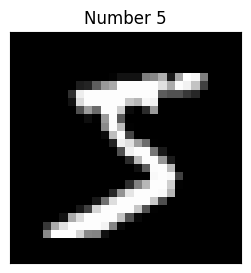

x-train:(60000, 28, 28), y-train:(60000,)
x-test:(10000, 28, 28),  y-test:(10000,)


In [2]:
# importando os dados do MNIST:
(x_train, y_train), (x_test, y_test) = carregar_mnist()

<font size=3>

Para alimentar o modelo de rede neural, precisamos reformar os dados de modo que as imagens $x$ sejam aplainadas $-$ _i.e._, todas as linhas da matriz são concatenados em um único vetor $-$ e normalizadas. Já para os dados de rótulos $y$, precisamos realizar uma codificação especial de _número inteiro_ para _distribuição de probabilidade_, uma vez que as redes neurais melhor retornam números reais do que interios. 

Tal codificação é conhecida como __one-hot encoding__. Nela, tratamos dados de múltiplas classes, como os rótulos de dígitos $(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)$. O método consiste em representar um rótulo como a posição de máxima probabilidade em um vetor cujo tamanho corresponde ao número total de classes. Nesse vetor, a posição associada ao rótulo recebe o valor 1 (indicando probabilidade máxima), enquanto todas as demais posições são preenchidas com 0 (indicando ausência de probabilidade).

$0:(1,0,0,0,0,0,0,0,0,0);\; 1: (0,1,0,0,0,0,0,0,0,0);\; \cdots;\; 9: (0,0,0,0,0,0,0,0,0,1)$

Para o dígito $\mathbf 3$, por exemplo, o modelo poderá retornar $(2.4,6.2,1.2,\mathbf{9.6},0.8,4.7,3.1,1.7,5.3,4.3)$, indicando uma maior probabilidade da posição 3.

In [3]:
# importando dados reformados: 
rotulo_exemplo = y_train[0]

(x_train, y_train), (x_test, y_test) = carregar_mnist(reformar=True)

print("\nRótulo exemplo:", rotulo_exemplo)
print("One-hot encoding:", y_train[0])

x-train:(60000, 784), y-train:(60000, 10)
x-test:(10000, 784),  y-test:(10000, 10)

Rótulo exemplo: 5
One-hot encoding: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


2024-12-05 16:00:16.284989: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### __2. Modelagem da rede neural:__ [<font size=3>(ver na teoria)](1-intro.ipynb/#mlp_modeling)
<font size=3>
 
2.1 Definir formato da camada inicial;\
2.2 Definir o formato da camada de saída e sua [função de ativação](https://en.wikipedia.org/wiki/Activation_function);\
2.3 Definir as demais camadas.


In [4]:
In = keras.Input(shape=(x_train.shape[1],))

x = layers.Dense(300, activation="relu")(In)

x = layers.Dense(100, activation="relu")(x)

Out = layers.Dense(y_train.shape[1], activation="softmax")(x)

model = keras.Model(inputs=In, outputs=Out)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

<a id='compilacao'></a>

### __3. Compilação do modelo:__
<font size=3>

3.1 Definir [otimizador](https://keras.io/api/optimizers/);\
3.2 Definir [função de custo](https://keras.io/api/losses/);\
3.3 Definir [métrica](https://keras.io/api/metrics/).


In [5]:
model.compile(optimizer="SGD", loss="categorical_crossentropy", metrics=['acc'])

### __4. Treinamento e validação do modelo__
<font size=3>
    
Neste processo, o otimizador utiliza os dados de treinamento para atualizar os parâmetros internos do modelo (como _pesos_, _vieses_ etc.) ao longo das épocas, minimizando ou maximizando a função de perda. Paralelamente, o desempenho do modelo é avaliado a cada época usando os dados de validação. Nesta etapa do fluxo de trabalho, projetamos a arquitetura da rede neural com o objetivo de evitar tanto o __superajuste__ quanto o __subajuste__ ([overfitting/underfitting](https://www.geeksforgeeks.org/underfitting-and-overfitting-in-machine-learning/)).


In [6]:
%%time
val_split = 0.0 # 0.2

report = model.fit(x_train, y_train, validation_split=val_split, batch_size=200, epochs=50)

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.4972 - loss: 1.7958
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8479 - loss: 0.6585
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8828 - loss: 0.4645
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8952 - loss: 0.3941
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9030 - loss: 0.3532
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9119 - loss: 0.3204
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9140 - loss: 0.3053
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.9189 - loss: 0.2911
Epoch 9/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9233 - loss: 0.2723
Epoch 10/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9231 - loss: 0.2710
Epoch 11/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9288 - loss: 0.2554
Epoch 12/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.9302 - loss: 0.2464
Epoch 13/50
300/300 ━━━━━

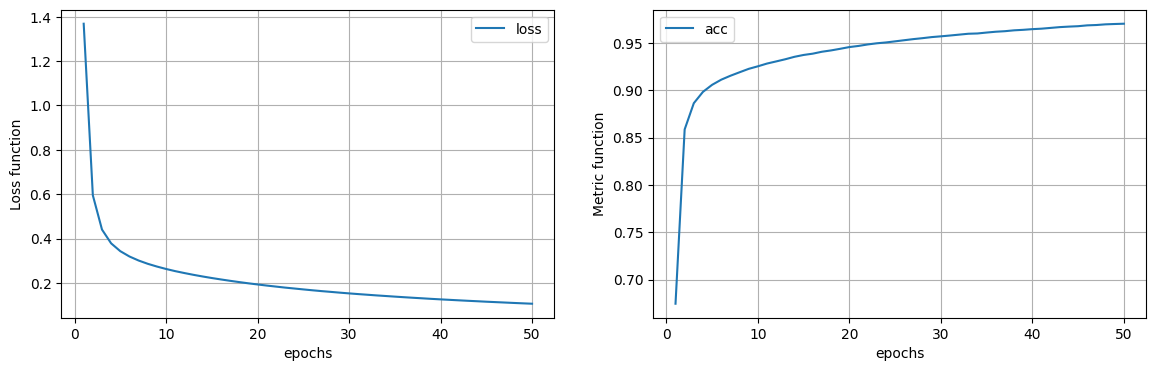

In [7]:
report.history

loss = report.history['loss']
acc = report.history['acc']

if val_split:
    val_loss = report.history['val_loss']
    val_acc = report.history['val_acc']

epochs = np.linspace(1, len(loss), len(loss))


fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].plot(epochs, loss, label="loss")
ax[1].plot(epochs, acc, label="acc")

if val_split: 
    ax[0].plot(epochs, val_loss, label="val-loss")
    ax[1].plot(epochs, val_acc, label="val-acc")

ax[0].set_ylabel("Loss function")
ax[1].set_ylabel("Metric function")

for i in [0, 1]:
    ax[i].set_xlabel("epochs")
    ax[i].legend()
    ax[i].grid()

plt.show()

### __6. Avaliar o modelo com dados de teste__:

In [8]:
model.evaluate(x_test, y_test, batch_size=200)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.9613 - loss: 0.1391


[0.11890743672847748, 0.9661999940872192]

### __7. Salvar os parâmetros do modelo__:

<font size=3>
    
Para __carregar__ e fazer predições com o modelo treinado, ver notebook [3-pratica-carregar_modelo](3-pratica-carregar_modelo.ipynb).